In [1]:
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 用线性Autoencoder实现PCA

In [3]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

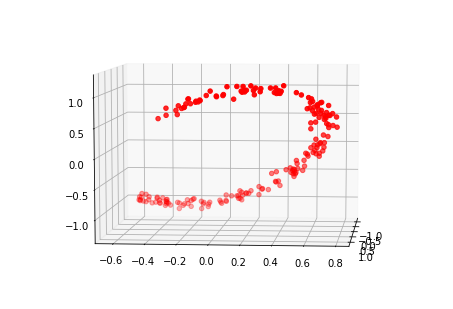

In [17]:
fig = plt.figure()
ax = Axes3D(fig) 
ax.view_init(elev=7., azim=5)
ax.scatter(data[:, 0], data[:, 1], data[:, 0], c='r')
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [7]:
n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [9]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteraton in range(n_iterations):
        sess.run(training_op, feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

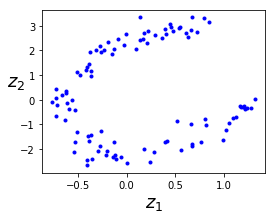

In [11]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(np.float32).reshape(-1, 28 * 28) / 255.
X_test = X_test.astype(np.float32).reshape(-1, 28 * 28) / 255

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.float32)

In [6]:
def shuffle_batch(X, batch_size):
    idx = np.random.permutation(len(X))
    n_batches = len(X) / batch_size
    for batch_idx in np.array_split(idx, n_batches):
        X_batch = X[batch_idx]
        yield X_batch

# Deep Autoencoder

In [12]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

he_init = tf.contrib.layers.variance_scaling_initializer()

l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

hidden1 = tf.layers.dense(X, n_hidden1, 
                          activation=tf.nn.elu, 
                          kernel_initializer=he_init,
                          kernel_regularizer=l2_regularizer)
hidden2 = tf.layers.dense(hidden1, n_hidden2, 
                          activation=tf.nn.elu, 
                          kernel_initializer=he_init,
                          kernel_regularizer=l2_regularizer)
hidden3 = tf.layers.dense(hidden2, n_hidden3, 
                          activation=tf.nn.elu, 
                          kernel_initializer=he_init,
                          kernel_regularizer=l2_regularizer)
outputs = tf.layers.dense(hidden3, n_outputs, 
                          kernel_initializer=he_init,
                          kernel_regularizer=l2_regularizer)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_loss)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [13]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch in shuffle_batch(X_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print(epoch, "Training mse:", loss_train)
        saver.save(sess, "./model/autoencoder.ckpt")

0 Training mse: 0.023810685
1 Training mse: 0.013262189
2 Training mse: 0.0111905765
3 Training mse: 0.010266581
4 Training mse: 0.010843426


INFO:tensorflow:Restoring parameters from ./model/autoencoder.ckpt


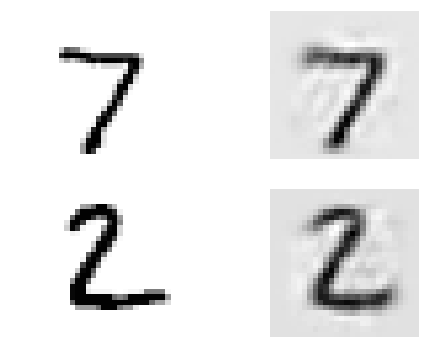

In [14]:
with tf.Session() as sess:
    saver.restore(sess, "./model/autoencoder.ckpt")
    X_test_2 = X_test[:2]
    outputs_val = outputs.eval(feed_dict={X: X_test_2})
    
fig = plt.figure(figsize=(8, 3 * 2))
for digit_index in range(2):
    plt.subplot(2, 2, digit_index * 2 + 1)
    plt.imshow(X_test_2[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.subplot(2, 2, digit_index * 2 + 2)
    plt.imshow(outputs_val[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")

# Tying weights

In [19]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [20]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")
weights4 = tf.transpose(weights1, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [21]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch in shuffle_batch(X_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print(epoch, "Training mse:", loss_train)
        saver.save(sess, "./model/autoencoder.ckpt")

0 Training mse: 0.014976371
1 Training mse: 0.01633146
2 Training mse: 0.017098986
3 Training mse: 0.016191907
4 Training mse: 0.017081067


INFO:tensorflow:Restoring parameters from ./model/autoencoder.ckpt


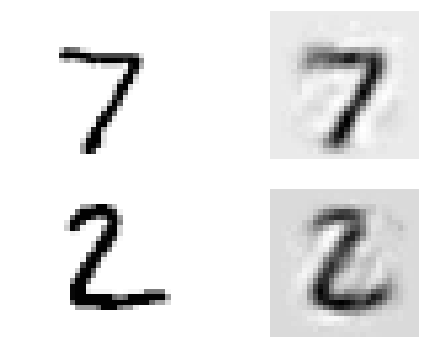

In [22]:
with tf.Session() as sess:
    saver.restore(sess, "./model/autoencoder.ckpt")
    X_test_2 = X_test[:2]
    outputs_val = outputs.eval(feed_dict={X: X_test_2})
    
fig = plt.figure(figsize=(8, 3 * 2))
for digit_index in range(2):
    plt.subplot(2, 2, digit_index * 2 + 1)
    plt.imshow(X_test_2[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.subplot(2, 2, digit_index * 2 + 2)
    plt.imshow(outputs_val[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")

# 在多个图中分开训练一个Autoencoder

In [24]:
reset_graph()

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])

        hidden = tf.layers.dense(X, n_neurons, 
                                 activation=hidden_activation,
                                 kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg),
                                 name="hidden")
        outputs = tf.layers.dense(hidden, n_inputs, 
                                  activation=output_activation, 
                                  kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                  kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg),
                                  name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            for X_batch in shuffle_batch(X_train, batch_size):
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print(epoch, "Training MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [25]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(X_train=X_train, 
                                                  n_neurons=300, 
                                                  n_epochs=4, 
                                                  batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(X_train=hidden_output, 
                                      n_neurons=150, 
                                      n_epochs=4, 
                                      batch_size=150)

0 Training MSE: 0.018673144
1 Training MSE: 0.019126505
2 Training MSE: 0.019383658
3 Training MSE: 0.018060237
0 Training MSE: 0.0045647575
1 Training MSE: 0.0043105115
2 Training MSE: 0.0045071193
3 Training MSE: 0.0044832327


In [26]:
reset_graph()

n_inputs = 28 * 28
X = tf.placeholder(tf.float32, shape=(None, n_inputs))
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

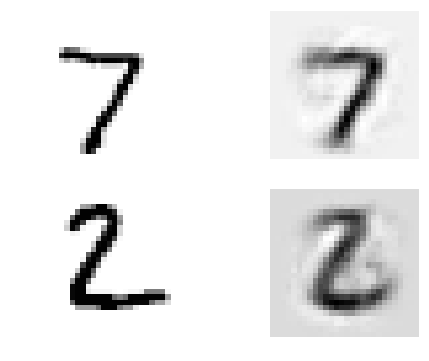

In [27]:
with tf.Session() as sess:
    X_test_2 = X_test[:2]
    outputs_val = outputs.eval(feed_dict={X: X_test_2})
    
fig = plt.figure(figsize=(8, 3 * 2))
for digit_index in range(2):
    plt.subplot(2, 2, digit_index * 2 + 1)
    plt.imshow(X_test_2[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.subplot(2, 2, digit_index * 2 + 2)
    plt.imshow(outputs_val[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")

# 在一个图中分开训练一个Autoencoder

In [39]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [40]:
with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)
    
with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=[train_vars])

In [41]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [42]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase {}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            for X_batch in shuffle_batch(X_train, batch_sizes[phase]):
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_train})
            print(epoch, "Training mse:", loss_train)
            saver.save(sess, "./model/autoencoder.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: X_test})
    print("Test mse:", loss_test)

Training phase 1
0 Training mse: 0.018840361
1 Training mse: 0.018991342
2 Training mse: 0.019227881
3 Training mse: 0.01949263
Training phase 2
0 Training mse: 0.0039787167
1 Training mse: 0.0038523325
2 Training mse: 0.00392503
3 Training mse: 0.004012286
Test mse: 0.023164956


INFO:tensorflow:Restoring parameters from ./model/autoencoder.ckpt


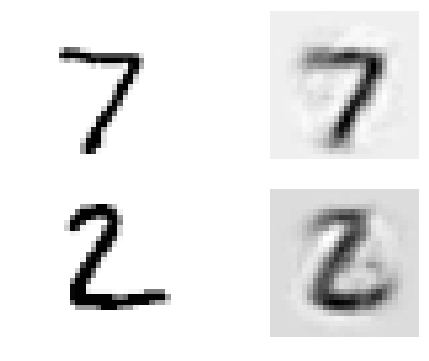

In [43]:
with tf.Session() as sess:
    saver.restore(sess, "./model/autoencoder.ckpt")
    X_test_2 = X_test[:2]
    outputs_val = outputs.eval(feed_dict={X: X_test_2})
    
fig = plt.figure(figsize=(8, 3 * 2))
for digit_index in range(2):
    plt.subplot(2, 2, digit_index * 2 + 1)
    plt.imshow(X_test_2[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.subplot(2, 2, digit_index * 2 + 2)
    plt.imshow(outputs_val[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")

# 缓存冻结层输出

In [46]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase {}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: X_train})
        for epoch in range(n_epochs[phase]):
            if phase == 1:
                for X_batch in shuffle_batch(hidden1_cache, batch_size):
                    feed_dict = {hidden1: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            else:
                for X_batch in shuffle_batch(X_train, batch_size):
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print(epoch, "Training mse:", loss_train)
            saver.save(sess, "./model/autoencoder.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: X_test})
    print("Test mse:", loss_test)

Training phase 1
0 Training mse: 0.019054843
1 Training mse: 0.01926956
2 Training mse: 0.018565038
3 Training mse: 0.018962618
Training phase 2
0 Training mse: 0.0040466143
1 Training mse: 0.0038203613
2 Training mse: 0.0040882947
3 Training mse: 0.0039782245
Test mse: 0.022951353


INFO:tensorflow:Restoring parameters from ./model/autoencoder.ckpt


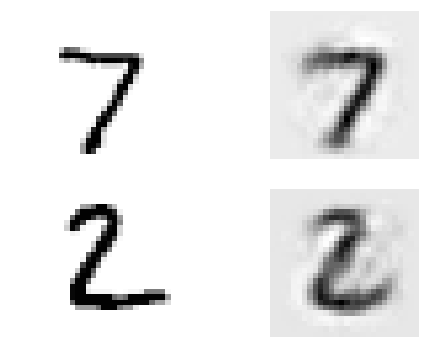

In [47]:
with tf.Session() as sess:
    saver.restore(sess, "./model/autoencoder.ckpt")
    X_test_2 = X_test[:2]
    outputs_val = outputs.eval(feed_dict={X: X_test_2})
    
fig = plt.figure(figsize=(8, 3 * 2))
for digit_index in range(2):
    plt.subplot(2, 2, digit_index * 2 + 1)
    plt.imshow(X_test_2[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.subplot(2, 2, digit_index * 2 + 2)
    plt.imshow(outputs_val[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")